# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [914]:
# According to the paper, the dataset were collected with 17 campaigns between 2008 - 2010.
# "The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts."

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1589]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Some sklearn tools for preprocessing and building a pipeline. 
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.svm import SVC

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [1591]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [1593]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no


In [1595]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



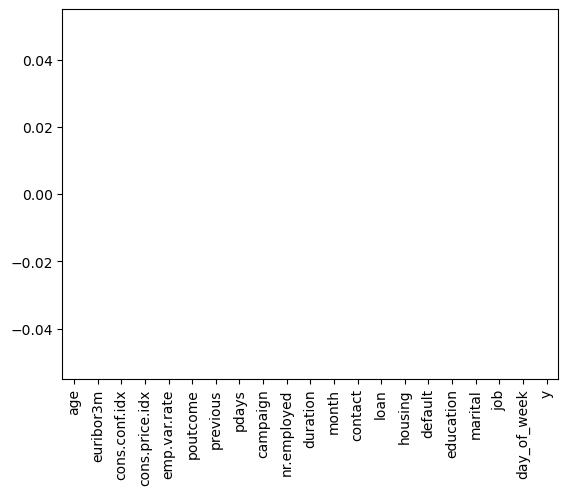

In [1598]:
# check to see if there are any NAN values in the data
df.isnull().values.any()

# plot which category has the most NAN fields just to be sure
df.isnull().sum().sort_values().plot(kind = 'bar')
plt.show()

In [1600]:
# We can clearly see that there are no NAN datafield.  The description asks the user to drop 'duration'.
# "Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model."

In [1602]:
# Droping the 'Duration'
df = df.drop(['duration'], axis=1)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [1605]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [1607]:
# The business objective is to apply various classication methods to the Bank Marketing data set.  Then compare the KNN, logistic regression
# decision trees, and support vector machines. See which one works best for this dataset.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [1611]:
# Separate the data to the X,y for modeling
y = df["y"].map({"no":0, "yes":1})
X = df.drop("y", axis=1)

In [1613]:
y.dtypes

dtype('int64')

In [1615]:
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

In [1617]:
# For the yes/no question, there are an unknown class, we have to process as a non binary category in the one hot encoder

num_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", 
                "cons.price.idx", "cons.conf.idx","euribor3m", "nr.employed"]

cat_features = ["job", "marital", "education","default", "housing", "loan",
                "contact", "month", "day_of_week", "poutcome"]

In [1619]:
# build a Column transformer to onehotencode the Category features
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [1622]:
# split the into X_train, X_test, y_train, y_test with stratify = y to maintain sample proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [1627]:
# Logistic Regression shall be our first model in order to establish a baseline performance.  All other classifer should aim to beat it to be useful
# in our example since logistic regression is simplist and least resource intense.  Therefore, if we utilize other models, we should make that the
# other models are best bang for the buck.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [1632]:
# Logistic Regression
lr_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", LogisticRegression(penalty='l2',class_weight="balanced", solver="liblinear", random_state=42))])

### Problem 9: Score the Model

What is the accuracy of your model?

In [1635]:
# use GridSearchCV to take a look at lr_model or Logistic Regression
start_time = time.time()
gs_lr = GridSearchCV(lr_model, {"model__C": [0.5, 1, 1.3, 1.4, 1.5]}, n_jobs=-1, cv=5, scoring="accuracy")
gs_lr.fit(X_train, y_train)
end_time = time.time()
lr_model_time = (end_time - start_time)

In [1636]:
print(gs_lr.best_params_)
print(gs_lr.best_score_)

{'model__C': 1.3}
0.8276854188683794


In [1637]:
lr_model.set_params(**gs_lr.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('model',
                 LogisticRegression(C=1.3, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

In [1638]:
lr_model.get_params("model")

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('numerical', 'passthrough',
                                    ['age', 'campaign', 'pdays', 'previous',
                                     'emp.var.rate', 'cons.price.idx',
                                     'cons.conf.idx', 'euribor3m',
                                     'nr.employed']),
                                   ('categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['job', 'marital', 'education', 'default',
                                     'housing', 'loan', 'contact', 'month',
                                     'day_of_week', 'poutcome'])])),
  ('model',
   LogisticRegression(C=1.3, class_weight='balanced', random_state=42,
                      solver='liblinear'))],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('numerical

In [1639]:
# Measure the time taken to fit the model of Logistic Regression
start_time = time.time()
lr_model.fit(X_train, y_train)
end_time = time.time()

# Print the fit time
lr_model_time = lr_model_time +(end_time - start_time)
print(f'Fit time: {lr_model_time:.4f} seconds')

Fit time: 4.3184 seconds


In [1640]:
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

In [1641]:
# Train accuracy of Logistic Regression
lr_train_acc = accuracy_score(y_train, y_pred_train)

In [1642]:
#Train Accuracy of Logistic Regression
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     25583
           1       0.35      0.62      0.45      3248

    accuracy                           0.83     28831
   macro avg       0.65      0.74      0.67     28831
weighted avg       0.88      0.83      0.85     28831



In [1643]:
# Test accuracy of Logistic Regression
lr_test_acc = accuracy_score(y_test, y_pred_test)

In [1644]:
# Test Accuracy of Logistic Regression
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     10965
           1       0.36      0.64      0.46      1392

    accuracy                           0.83     12357
   macro avg       0.66      0.75      0.68     12357
weighted avg       0.88      0.83      0.85     12357



### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [1646]:
# Build all the models to be used

# KNN Model
knn_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", KNeighborsClassifier())])


In [1647]:
# Decision Tree Model
dt_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", DecisionTreeClassifier(class_weight="balanced"))])

In [1648]:
# SVM Models
svm_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", SVC(kernel = 'linear'))])

In [1649]:
# Use GridSearchCV to take a look at KNN Model

start_time = time.time()
gs_knn = GridSearchCV(knn_model, {"model__n_neighbors": [3,5,10],
                              "model__weights":['uniform', 'distance'],
                              "model__metric":['euclidean','manhattan']},
                 n_jobs=-1, cv=2, scoring="accuracy")
gs_knn.fit(X_train, y_train)
end_time = time.time()
knn_model_time = end_time - start_time 

In [1650]:
print(gs_knn.best_params_)
print(gs_knn.best_score_)

{'model__metric': 'manhattan', 'model__n_neighbors': 10, 'model__weights': 'uniform'}
0.8952863248258092


In [1651]:
knn_model.set_params(**gs_knn.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=10))])

In [1652]:
# Measure the time taken to fit Decsision Tree the model
start_time = time.time()
knn_model.fit(X_train, y_train)
end_time = time.time()

# Print the fit time
knn_model_time = knn_model_time + (end_time - start_time )
print(f'Fit time: {knn_model_time:.4f} seconds')

knn_model.fit(X_train, y_train)

Fit time: 9.6008 seconds


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=10))])

In [1666]:
# KNN y_pred_train and y_pred_test
y_pred_train = knn_model.predict(X_train)
y_pred_test = knn_model.predict(X_test)

In [1667]:
# Train accuracy of KNN 
knn_train_acc = accuracy_score(y_train, y_pred_train)

In [1668]:
# Print Classification Report KNN
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     25583
           1       0.70      0.27      0.39      3248

    accuracy                           0.90     28831
   macro avg       0.81      0.63      0.67     28831
weighted avg       0.89      0.90      0.89     28831



In [1669]:
# Test accuracy of KNN
knn_test_acc = accuracy_score(y_test, y_pred_test)

In [1670]:
# Print Classification Report Decision Tree
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10965
           1       0.64      0.22      0.33      1392

    accuracy                           0.90     12357
   macro avg       0.77      0.60      0.64     12357
weighted avg       0.88      0.90      0.88     12357



In [1671]:
# Now, let's do Decision Tree

In [1672]:
# Use decision tree with Grid Search CV
start_time = time.time()
gs_dt = GridSearchCV(dt_model, {"model__max_depth": [3, 5, 7], 
                             "model__min_samples_split": [2, 5]}, 
                  n_jobs=-1, cv=5, scoring="accuracy")

gs_dt.fit(X_train, y_train)
end_time = time.time()
dt_model_time = end_time - start_time

In [1673]:
print(gs_dt.best_params_)
print(gs_dt.best_score_)

{'model__max_depth': 5, 'model__min_samples_split': 2}
0.8510276243107213


In [1674]:
dt_model.set_params(**gs_dt.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5))])

In [1675]:
# Measure the time taken to fit Decsision Tree the model
start_time = time.time()
dt_model.fit(X_train, y_train)
end_time = time.time()

# Print the fit time
dt_model_time = dt_model_time + (end_time - start_time)
print(f'Fit time: {dt_model_time:.4f} seconds')

dt_model.fit(X_train, y_train)

Fit time: 0.8815 seconds


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5))])

In [1676]:
# Decision Tree y_pred_train and y_pred_test
y_pred_train = dt_model.predict(X_train)
y_pred_test = dt_model.predict(X_test)

In [1677]:
# Train accuracy of Decision Tree
dt_train_acc = accuracy_score(y_train, y_pred_train)

In [1678]:
# Print Classification Report Decision Tree
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     25583
           1       0.40      0.60      0.48      3248

    accuracy                           0.85     28831
   macro avg       0.67      0.74      0.70     28831
weighted avg       0.88      0.85      0.87     28831



In [1679]:
# Test accuracy of Decision Tree
dt_test_acc = accuracy_score(y_test, y_pred_test)

In [1680]:
# Print Classification Report Decision Tree
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     10965
           1       0.41      0.62      0.49      1392

    accuracy                           0.86     12357
   macro avg       0.68      0.75      0.70     12357
weighted avg       0.89      0.86      0.87     12357



In [1681]:
# Now, let us SVC with Grid Search CV

In [1682]:
# Initialize GridSearchCV
start_time = time.time()
gs_svm = GridSearchCV(svm_model, {'model__C': [0.1, 1.0, 10, 100], 
                              'model__kernel': ['linear']}, cv=2, n_jobs=-1, verbose=1)
gs_svm.fit(X_train, y_train)
end_time = time.time()
svm_model_time = end_time - start_time  

Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [1683]:
print(gs_svm.best_params_)
print(gs_svm.best_score_)

{'model__C': 0.1, 'model__kernel': 'linear'}
0.894627322784296


In [1684]:
svm_model.set_params(**gs_svm.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('model', SVC(C=0.1, kernel='linear'))])

In [1685]:
# Measure the time taken to fit the model
start_time = time.time()
svm_model.fit(X_train, y_train)
end_time = time.time()

# Print the fit time
svm_model_time = svm_model_time + (end_time - start_time)
print(f'Fit time: {svm_model_time:.4f} seconds')

svm_model.fit(X_train, y_train)

Fit time: 28.1387 seconds


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('model', SVC(C=0.1, kernel='linear'))])

In [1686]:
# SVC y_pred_train and y_pred_test
y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

In [1687]:
# Train accuracy of SVC
svm_train_acc = accuracy_score(y_train, y_pred_train)

In [1688]:
# Print Classification SVC on training
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     25583
           1       0.57      0.21      0.31      3248

    accuracy                           0.89     28831
   macro avg       0.74      0.60      0.63     28831
weighted avg       0.87      0.89      0.87     28831



In [1689]:
# Print Classification SVC on testing
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10965
           1       0.58      0.20      0.29      1392

    accuracy                           0.89     12357
   macro avg       0.74      0.59      0.62     12357
weighted avg       0.87      0.89      0.87     12357



In [1690]:
# Test accuracy of SVC
svm_test_acc = accuracy_score(y_test, y_pred_test)

In [1691]:
# Create a sample array
array = np.array([["Logistic Regression", lr_model_time, lr_train_acc, lr_test_acc ],
                  ["KNN Model", knn_model_time, knn_train_acc, knn_test_acc],
                  ["Decision Tree", dt_model_time, dt_train_acc, dt_test_acc], 
                  ["Support Vector Machine", svm_model_time, svm_train_acc, svm_test_acc]])

# Convert the array to a DataFrame
df1 = pd.DataFrame(array, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])

# Display the DataFrame
print(df1.round(3))

                    Model          Train Time      Train Accuracy  \
0     Logistic Regression   4.318376779556274  0.8288647636224897   
1               KNN Model   9.600786685943604  0.9045818736776386   
2           Decision Tree  0.8815054893493652  0.8539072526100379   
3  Support Vector Machine  28.138669729232788  0.8931358607054907   

        Test Accuracy  
0  0.8322408351541636  
1  0.8981953548595938  
2  0.8553046856033018  
3  0.8932588816055677  


In [1692]:
# From the data collected on Train Time, Train Accuracy, and Test Accurarcy, the best model is the KNN model.  It shows the best accuracry 
# while the train time is still relatively acceptable at 10 Seconds.  However, if one is very short on time, the Decision Tree seems to be able 
# to make a judgement in under 1 second.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [1694]:
# False Positive, means the client do NOT SUBSCRIBED to term deposit, but the model thinks he did.
# False Negative, means the client SUBSCRIBED to term deposit, but the model said he dont.

In [1695]:
# Try to take out the gender feature and see if the model improves
# This instructions doesn't make sense

In [1696]:
# Hyperparameter tuning and grid search. All of our models have additional hyperparameters to tune and explore. 
# For example the number of neighbors in KNN or the maximum depth of a Decision Tree.
# This has already been done to see which one is the best.

##### Questions